**Part 3 - Mapping Closure in 2D for f_ZB**

This notebook implements the mapping closure developed by (Chen, H. 1989) and extended by (Pope, S.B. 1991) for a two-dimensional (2D) problem where the vector of random variables $\bm{Y} = (Z,B)$ inlcues the vertical height and the buoyancy $B$.


*Evolution equation*

The joint pdf $f_{\bm{Y}}$ evolves according to the forward Kolmogorov equation given by

\begin{equation}
\frac{\partial f_{\bm{Y}} }{ \partial t}= -\frac{\partial }{\partial y_i} \bm{D}^{(1)}_i f_{\bm{Y}}  + \frac{\partial^{2}}{\partial y_i \partial y_j} \bm{D}^{(2)}_{ij} f_{\bm{Y}},
\end{equation}

where 

\begin{equation}
  \bm{D}^{(1)}=
  \phi\,\mathbb{E}_{\bm{Y}_{t}|\partial\Omega}
 \begin{bmatrix}
 0 \\
 \alpha_{1}\,\bm{n}\cdot\nabla B_{t} \\
 \end{bmatrix}
  \frac{f_{\bm{Y}|\partial\Omega}}{f_{\bm{Y}}} .
\end{equation}

arises due to diffusive fluxes at the boundary, which must be specified. The diffusion term for our system us given by either
\begin{equation}
  \bm{D}^{(2)}=-\alpha_{1}
  \mathbb{E}_{\bm{Y}_{t}}
    \begin{bmatrix}
    -1 & 0 \\
    0 & |\nabla B_{t}|^{2}\\
  \end{bmatrix},
\end{equation}
or
\begin{equation}
  \bm{D}^{(2)}=-\alpha_{1}
  \mathbb{E}_{\bm{Y}_{t}}
    \begin{bmatrix}
    0 & \partial_Z B_t/2 \\
    \partial_Z B_t/2  & |\nabla B_{t}|^{2}\\
  \end{bmatrix}.
\end{equation}
However to avail of the mapping closure (Pope, S.B. 1991) we will use to model these terms we will make the assumption that
\begin{equation}
  \frac{\partial^{2}}{\partial y_i \partial y_j} \bm{D}_{ij}^{(2)} f_{\bm{Y}} \approx -\frac{\partial }{ \partial y_i} \mathbb{E}_{\bm{Y}_{t}} [ \alpha_{ij} \nabla^{2} \bm{Y}^j_{t}] f_{\bm{Y}},
\end{equation}
which at least for the 1D problem has been shown to be equivalent. For now we consider only the unforced system when $\bm{D}^{(1)}_{i} = 0$ before later reintroducing these terms.

*Mapping closure*

Corresponding to the random vector $\bm{Y} = (Y_1,Y_2)$ we now have a vector of Gaussian random fields $\bm{\theta} = (\theta_1,\theta_2)$. The (now multidimensional) mapping $\mathscr{Y}_{\alpha}(-,t):\mathbb{R}^{\alpha} \rightarrow \mathbb{R}$ which maps the Gaussian field(s) to the surrogate field $\tilde{Y}_{\alpha}$ is hierarchical in the sense that 
\begin{align*}
    \tilde{Y}_1(\bm{x},t) &= \mathscr{Y}_{1}(\theta_1(J_1(t)\bm{x}),t), \\
    \tilde{Y}_2(\bm{x},t) &= \mathscr{Y}_{2}(\theta_1(J_1(t)\bm{x}),\theta_2(J_2(t)\bm{x}),t),
\end{align*}
such that $\mathscr{Y}_{\alpha}$ only depends on the subset $[\bm{\theta}]_{\alpha}$

*Mapping equation*

The mapping $\mathscr{Y}_{\alpha}(-,t)$ evolves according to

\begin{equation}
\frac{\partial \mathscr{Y}_{\alpha} }{\partial t} = \bm{D}^{(1)}_{\alpha} + \sum_{j=1}^{\alpha} \frac{\gamma_{\alpha}}{\tau_{j}(t)} \left( \frac{\partial^{2}}{\partial \eta_{j}^{2}} - \eta_{j}\frac{\partial }{ \partial \eta_{j} }\right)\mathscr{Y}_{\alpha},
\end{equation}

however for a simple domain such as a rectangular box we know that $f_Z(z;t) = 1$ is independent of time and is given by the uniform distribution. This implies that $\mathscr{Y}_1(\eta_1,t) = G(\eta_1)$, where $G$ denotes the conditional cumulative normal distribution and that we do not need to model this equation. 

When expanded the previous equation is therefore given by

\begin{equation}
\frac{\partial \mathscr{Y}_2 }{\partial t} = \gamma_2 \left[ \frac{1}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial \eta_{1}^{2}} - \eta_1\frac{\partial }{ \partial \eta_1 }\right) + \frac{1}{\tau_2(t)} \left( \frac{\partial^{2}}{\partial \eta_{2}^{2}} - \eta_2\frac{\partial }{ \partial \eta_2 }\right) \right] \mathscr{Y}_2,
\end{equation}
with $\tau_1(t) = 1$ as there is no stretching of this variable.


**Setup**

We first import the required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Currently all the code is written using Z for \mathscr{Y} and z for \eta I must change this

For the mapping equation we define a computational grid, on which the position vector $\bm{\eta} = (\eta_1,\eta_2)$ for the Gaussian random variables is defined.

In [2]:
# Time scales (cf. Taylor microscale)
t1 = 1
t2 = 1

# Boundary conditions
bc1 = 'Neumann'
bc2 = 'Neumann'

# Numerical resolution
N1 =32
N2 =64

# Domain
z1 = np.linspace(-4, 4, N1)
z2 = np.linspace(-6, 6, N2)

# 2d grid for gaussian random variables Y1 and Y2
I2 = np.ones(N2)
I1 = np.ones(N1)
z1_2d = np.kron(z1,I2).reshape((N1,N2))
z2_2d = np.kron(I1,z2).reshape((N1,N2))

*Differential operators*

To define the differential operators in the equations right hand sides we first define the gradient and Laplacian operators:

In [3]:
# Define the gradient & Laplacian operators
def grad(x):
  """Gradient operator ∂/∂x"""
  N = len(x)
  dx= x[1] - x[0] 
  D = np.zeros((N,N))
  for i in range(N):
    if i < N-1:
      D[i,i+1] = 1
    if i > 0:
      D[i,i-1] =-1
  return D/(2*dx)

def laplacian(x, bcs = 'Dirichlet'):
  """Laplacian ∂^2/∂x^2"""
  
  N = len(x)
  dx= x[1] - x[0] 

  L = np.zeros((N,N))
  for i in range(N):

    L[i,i] = -2.
    if i ==N-1:
      if bcs == 'Dirichlet':
        L[i,i-1] = 1
      elif bcs == 'Neumann':
        L[i,i-1] = 2
    elif i == 0:
      if bcs == 'Dirichlet':
        L[i,i+1] = 1
      elif bcs == 'Neumann':
        L[i,i+1] = 2
    else:
      L[i,i-1] = 1
      L[i,i+1] = 1

  return L/(dx**2)

def test_derivatives():
  """Check the derivatives are correctly implemented"""
  
  x = np.linspace(0, 2*np.pi, 256)
  
  D = grad(x)
  error_D = ( np.cos(x)[1:-1] - D.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_D,x=x[1:-1]) < 1e-07

  L = laplacian(x)
  error_L = (-np.sin(x)[1:-1] - L.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_L,x=x[1:-1]) < 1e-07

  return None

test_derivatives()

Using these operators the terms in the mapping equation are constructed using Kronecker products:

In [4]:
# Define the 1D equation operators 
D1_1d = grad(z1)
L1_1d = laplacian(z1, bcs = bc1)
Z1_1d = np.diag(z1)
I1_1d = np.eye(N1)

D2_1d = grad(z2)
L2_1d = laplacian(z2, bcs = bc2)
Z2_1d = np.diag(z2)
I2_1d = np.eye(N2)

# Take Kronecker products to obtain them in 2D
D1_2d = np.kron(D1_1d,I2_1d)
L1_2d = np.kron(L1_1d,I2_1d)
Z1_2d = np.kron(Z1_1d,I2_1d)

D2_2d = np.kron(I1_1d,D2_1d)
L2_2d = np.kron(I1_1d,L2_1d)
Z2_2d = np.kron(I1_1d,Z2_1d)

These are then assembled to make the right hand side operator for $\mathscr{Y}_2(\eta_1, \eta_2, t)$. For now we ignore the coefficients $\bm{D}^{(1)}_{\alpha}$ and concentrate on the differential operators only.

In [5]:
# Define the RHS operator for Y_2
L2 = (1/t1)*(L1_2d - Z1_2d@D1_2d) + (1/t2)*(L2_2d - Z2_2d@D2_2d)

*Initial conditions & forcing*

Using $\bm{\eta}$ as a dummy variable, this mapping is chosen such that the conditional cumulative distribution function satisfies
\begin{equation}
  F_{\alpha|\alpha-1}(\mathscr{Y}_{\alpha}([\bm{\eta}]_{\alpha},t), t)=G(\eta_{\alpha}),
\end{equation}
which taking a derivative with respect to $\eta_{\alpha}$ implies that
\begin{equation}
    f_{\alpha|\alpha-1}(\mathscr{Y}_{\alpha}([\bm{\eta}]_{\alpha},t)\frac{\partial \mathscr{Y}_{\alpha}}{\partial \eta_{\alpha}} = g(z_{\alpha})>0,
\end{equation}
and inturn that if the conditional density is strictly positive then $\partial_{\eta_{\alpha}}\mathscr{Y}_{\alpha}>0$.

To prescribe an initial condition for the mapping we make use of these relations by choosing the conditional cumulative distribution function specified in terms of an error function
\begin{equation}
F_{2|1}(\tilde{y}_1, \tilde{y}_2, t=0) = \frac{1}{2} [ 1 + \text{erf}(\frac{\eta_2}{\sigma_2 \sqrt{2}})  ], 
\end{equation}
where $\tilde{y}_i$ is used to refer to $\mathscr{Y}_i( [\bm{\eta}]_i,t)$, as this function has a well defined inverse also known as the quantile function of the normal distribution and thus makes it easy to invert for $\mathscr{Y}_2$. Implementing this relation below we calculate the initial condition.

In [6]:
from scipy.special import erf, erfinv

def G(z):
    return (1 + erf(z/np.sqrt(2)))/2

def g(z):
    return np.exp(-z**2/2)/np.sqrt(2*np.pi)

To recover the joint distribution $f_{\bm{Y}}(y_1, y_2)$ from the mapping we then make use of the second relation above.This is achieved by relating the mapping to the pdf of the Gaussian random variables for
\begin{align*}
    \frac{\partial \mathscr{Y}_1}{\partial \eta_1} f_{Y_1}( \mathscr{Y}_1(\eta_1,t), t) &= g(\eta_1), \\
    \frac{\partial \mathscr{Y}_1}{\partial \eta_1} & = g(\eta_1)
\end{align*}
and
\begin{equation}
    \frac{\partial \mathscr{Y}_2}{\partial \eta_2} f_{Y_2|Y_1}( \mathscr{Y}_1(y_1,t), \mathscr{Y}_2(\eta_1,\eta_2,t), t) = g(\eta_2),
\end{equation}
and then by inverting $\frac{\partial \mathscr{Y}_1}{\partial \eta_1}$ and $\frac{\partial \mathscr{Y}_2}{\partial \eta_2}$ on to the right hand side we recover $f_{Y_1}$ and $f_{Y_2|Y_1}$. The joint desnity is then readily obtained by multiplying these distributions
\begin{equation}
f_{\bm{Y}}(y_1, y_2) = f_{Y_2|Y_1}(y_1, y_2) f_{Y_1}(y_1),
\end{equation}
as implemented below along with plotting routines to show the mapping and to show the joint distribution.

In [7]:
# plt.rcParams.update(
#     {"text.usetex": True, 
#      "font.family": "sans-serif", 
#      "font.sans-serif": "Helvetica",
#       'text.latex.preamble': r'\usepackage{amsfonts}'
#      })

# Make the Y1 mapping 2D
def one_to_2d(Y1):
    return np.kron(Y1,I2) 

# Produce the joint pdf and all its marginals from the mapping
def map_to_pdf(z1,Y1,z2_2d,Y2):

    # Invert the mappings
    dY1_dη1 = g(z1) #= D1_1d@Y1 
    dY2_dη2 = D2_2d@Y2

    # Gaussian distribution
    g_1 = g(z1)
    g_2 = g(z2_2d).flatten()

    # Conditional pdfs
    fc_1 = g_1/dY1_dη1 # vector size N1
    fc_2 = g_2/dY2_dη2 # vector size N1*N2

    # Compute the marginal pdfs f_1,f_2
    f_1   = fc_1
    y1_1d = Y1
    assert (1 - np.trapz(y=f_1,x=y1_1d))**2 < 1e-03

    # f_2   = 
    # y2_1d = 
    # assert (1 - np.trapz(y=f_2,x=y2_1d))**2 < 1e-03

    # Compute the joint distribution f_12
    fj_12 = (fc_2*one_to_2d(fc_1)).reshape((N1,N2))

    # Compute the 2d grids
    y1_2d = one_to_2d(Y1).reshape((N1,N2))
    y2_2d = Y2.reshape((N1,N2))

    return y1_1d,f_1, y1_2d,y2_2d,fj_12

# Plot the mapping time-evolution
def plot_mapping(z1,Y1, z1_2d,z2_2d,Y2):
    """Plot the mapping components."""
    fig = plt.figure(figsize=(6,4),layout='constrained')

    ax1 = fig.add_subplot(1, 2, 1,projection="3d")  # equivalent but more general
    ax2 = fig.add_subplot(1, 2, 2)  # equivalent but more general

    # 2D plot for Y2
    surf = ax1.plot_surface(z1_2d,z2_2d, Y2.reshape((N1,N2)), cmap='RdBu',linewidth=0, antialiased=False)
    #fig.colorbar(surf, shrink=0.5, aspect=5,orientation='horizontal')
    ax1.set_title(r'$Y_2$')
    ax1.set_xlabel(r'$z_1$')
    ax1.set_ylabel(r'$z_2$')

    # 1D plot for Y1
    ax2.set_title(r'$Y_1$')
    ax2.plot(z1,Y1)
    ax2.set_xlabel(r'$z_1$')

    plt.show()

    return None

# plot the joint density
def plot_joint(y1_1d,f_1, y1_2d,y2_2d,f_12):
    """Plot the mapping components."""
    fig = plt.figure(figsize=(6,4),layout='constrained')

    ax1 = fig.add_subplot(1, 3, 1)

    # 2D plot for Y2
    # array C with shape (nrows, ncolumns) is plotted with the column number as X and the row number as Y
    # pc=ax1.pcolormesh(y1_2d,y2_2d,f_12, cmap='Reds')#,linewidth=0, antialiased=False)
    # ax1.set_xlabel(r'$y_1$')
    # ax1.set_ylabel(r'$y_2$')
    # fig.colorbar(pc)

    #pc=ax1.pcolormesh(y1_2d,y2_2d,f_12, cmap='Reds', norm='log')#,linewidth=0, antialiased=False)
    #ax1.set_xlabel(r'$z$')
    #ax1.set_ylabel(r'$b$')

    pc=ax1.pcolormesh(y2_2d,y1_2d,f_12, cmap='Reds', norm='log')#,linewidth=0, antialiased=False)
    ax1.set_xlabel(r'$b$')
    ax1.set_ylabel(r'$z$')
    fig.colorbar(pc)

    ax2 = fig.add_subplot(1, 3, 2) 
    
    #ax2.plot(y1_1d,f_1)
    #ax2.set_xlabel(r'$y_1$')
    #ax2.set_ylabel(r'$f_{Y_1}$')

    ax2.plot(y1_1d,f_1)
    ax2.set_xlabel(r'$z$')
    ax2.set_ylabel(r'$f_{Z}$')

    # ax3 = fig.add_subplot(1, 3, 3)
    # f_2 = np.zeros(N2)
    # for j in range(N2):
    #     f_2[j] = np.trapezoid(y=f_12[:,j],x=y1[:,j])
    # ax3.plot(y2[0,:],f_2)
    # ax3.set_xlabel(r'$y_2$')
    # ax3.set_ylabel(r'$f_{Y_2}$')

    plt.show()

    return None

We then pass these initial conditions to a time-stepping routine, and time-integrate forwards one time unit. 

In [8]:
# Standard deviations for initial condition
Y1 = G(z1)

σ2 = 1
Y2 = (erfinv(2*G(z2_2d) - 1)*σ2*np.sqrt(2)).flatten()

dt = 0.001
nt = 1000

for i in range(nt):
    Y2 +=  L2 @ Y2 * dt
    
    if i % (nt/4) == 0:
        print('time t = ',i*dt)
        #plot_mapping(z1,Y1, z1_2d,z2_2d,Y2)
        OUT = map_to_pdf(z1,Y1, z2_2d,Y2)
        plot_joint(*OUT)

The time evolution shows that the systems variance shrinks uniformly in $y_2$ (or equivalently $b$) as the diffusive terms mix the contents of the domain but their is no forcing to prevent the destruction of buoyancy variance.

To account for this we now include the diffusive fluxes which for our system appear as forcing terms

\begin{equation}
\frac{\partial \mathscr{Y}_2 }{\partial t} = \bm{D}^{(1)}_{2} + \gamma_2 \left[ \frac{1}{\tau_1(t)} \left( \frac{\partial^{2}}{\partial \eta_{1}^{2}} - \eta_1\frac{\partial }{ \partial \eta_1 }\right) + \frac{1}{\tau_2(t)} \left( \frac{\partial^{2}}{\partial \eta_{2}^{2}} - \eta_2\frac{\partial }{ \partial \eta_2 }\right) \right] \mathscr{Y}_2.
\end{equation}

which in the form of our forward Kolmogorov equation are given by 

\begin{equation}
  \bm{D}^{(1)}_2 =
  \phi\,\mathbb{E}_{\bm{Y}|\partial\Omega} \left[ \alpha_{1}\,\bm{n}\cdot\nabla Y_2 \right] \frac{f_{\bm{Y}|\partial\Omega}}{f_{\bm{Y}}}.
\end{equation}

To generate $\bm{D}^{(1)}_2$ we can specify a function based on our interpretation of simulation results, notably this is similar to the 1D forcing with the exception that it has not been integrated in $Z$. Below we provide several functions which approximate the forcing term suggested by numerical simulations. A deviation from the simulations forcing is that here we have applied a Gaussian filter to smooth the forcing.

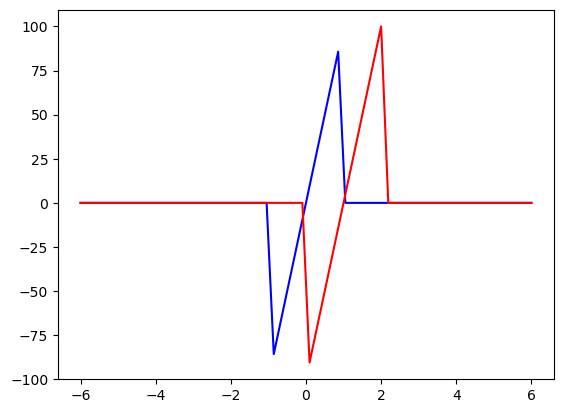

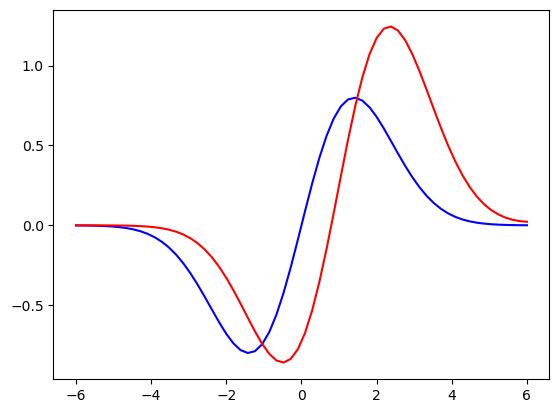

In [15]:
def D1_forcing(z,b, µ_bottom, µ_top, σ_bottom, σ_top):

    shape = (len(z), len(b))
    D1_2 = np.zeros(shape)

    D_z1 = np.where(b > µ_top + σ_top, 0, 100*(b-µ_top))
    D_z1 = np.where(b < µ_top - σ_top, 0, D_z1)

    D_z0 = np.where(b < µ_bottom - σ_bottom, 0, 100*(b-µ_bottom))
    D_z0 = np.where(b > µ_bottom + σ_bottom, 0, D_z0)

    D1_2[-1,:] = D_z1
    D1_2[0,:] = D_z0

    plt.plot(b,D_z1,'b-')
    plt.plot(b,D_z0,'r-')
    plt.show()

    # Apply a kernel to smooth it
    from scipy.ndimage import gaussian_filter
    D1_2 = gaussian_filter(D1_2, sigma=7)
    
    plt.plot(b,D1_2[-1,:],'b-')
    plt.plot(b,D1_2[ 0,:],'r-')
    plt.show()

    return D1_2.flatten()

# RBC
µ_bottom = 1
µ_top = 0
σ_bottom = 1
σ_top = 1

F2 = D1_forcing(z1,z2, µ_bottom, µ_top, σ_bottom, σ_top)

time t =  0.0


/tmp/ipykernel_45305/240765199.py:87: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc=ax1.pcolormesh(y2_2d,y1_2d,f_12, cmap='Reds', norm='log')#,linewidth=0, antialiased=False)


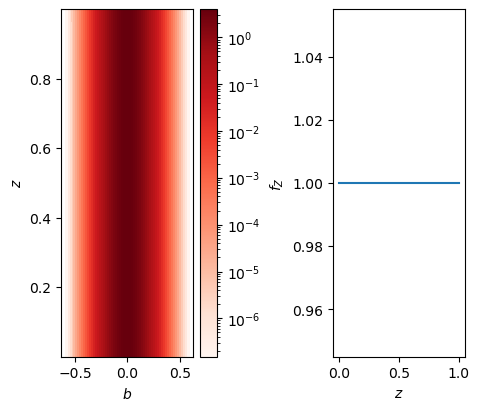

time t =  0.5


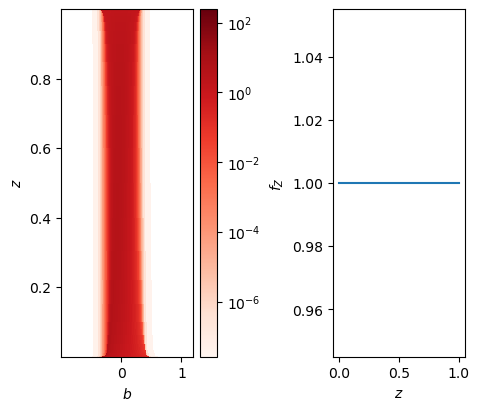

time t =  1.0


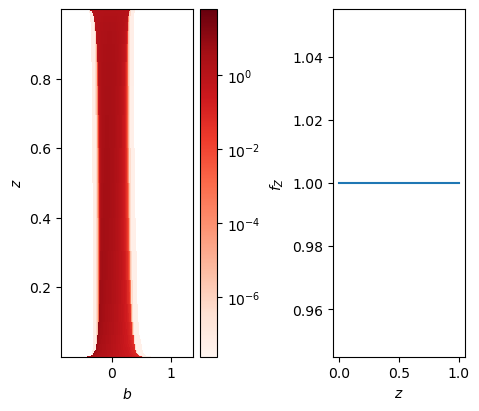

time t =  1.5


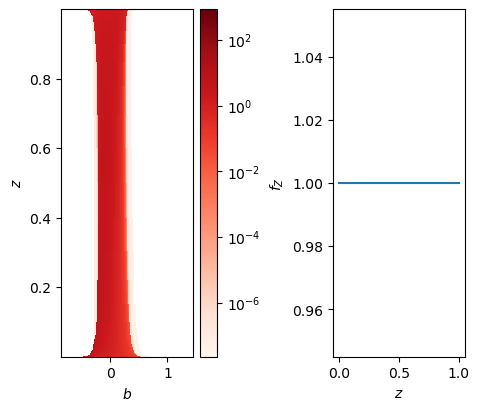

time t =  2.0


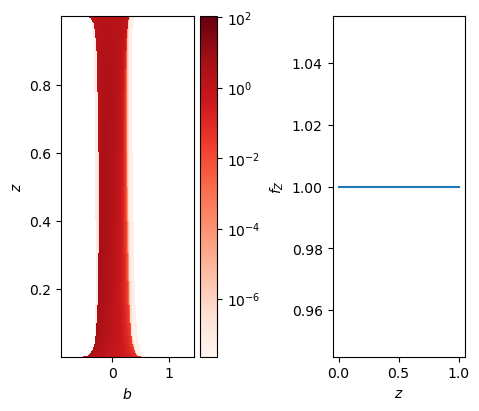

time t =  2.5


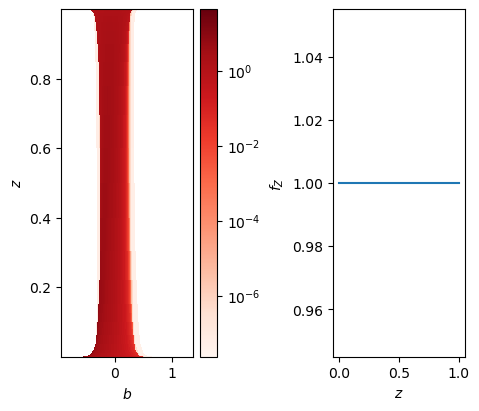

time t =  3.0


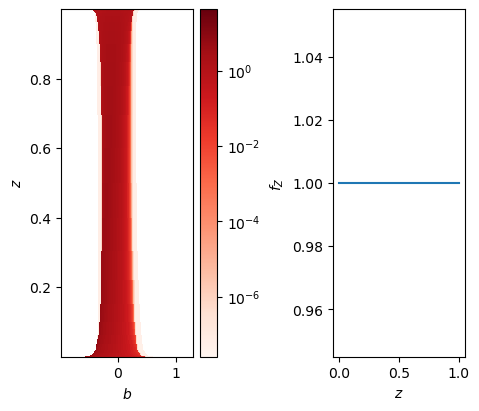

time t =  3.5


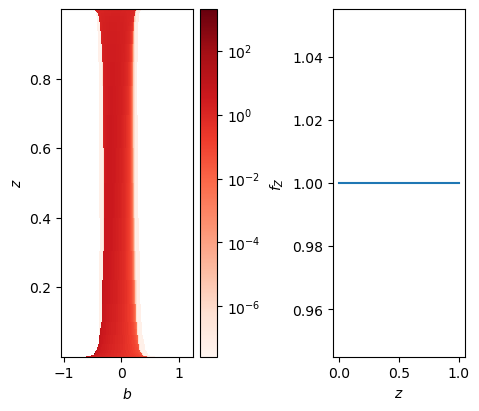

time t =  4.0


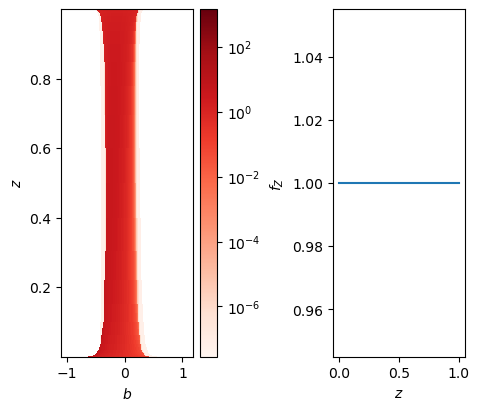

time t =  4.5


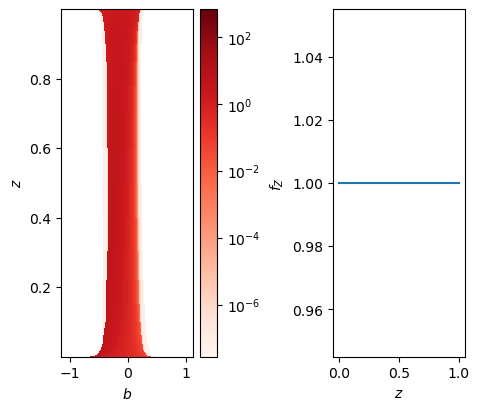

In [16]:
# Initial condition
Y1 = G(z1)

σ2 = .1
Y2 = (erfinv(2*G(z2_2d) - 1)*σ2*np.sqrt(2)).flatten()

Q_avg = 0  # Internal heating term

#F2 = 0*Y2 # (z_1, z_2) or (z,b)

dt = 0.001
T = 5
nt = int(T/dt)

for i in range(nt):
    Y2 += Q_avg*dt + F2*dt + L2 @ Y2* dt    
    
    if i % (nt/10) == 0:
        print('time t = ',i*dt)
        #plot_mapping(z1,Y1, z1_2d,z2_2d,Y2)
        OUT = map_to_pdf(z1,Y1, z2_2d,Y2)
        plot_joint(*OUT)

The previous results show that while aspects of the observed PDF for this case can be simulated using the 2D model, the true PDF cannot be represented by a forcing which is localised at the boundaries. For this reason we now turn to including $W$ in the model.